<a href="https://colab.research.google.com/github/RJonMshka/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/master/ensemble_original_3_month_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning the Ensemble Strategy git repository for availablility of important modules and dataset.

In [35]:
!git clone https://github.com/RJonMshka/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020.git


Cloning into 'Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020'...
remote: Enumerating objects: 758, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 758 (delta 3), reused 6 (delta 2), pack-reused 749
Receiving objects: 100% (758/758), 37.53 MiB | 19.14 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [36]:
%cd Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020

/content/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020


In [37]:
!pip install -r requirements.txt

Setting up the environment

In [38]:
# common library
import pandas as pd
import numpy as np
import time
import gym
import os

# RL models from stable-baselines
from stable_baselines import PPO2
from stable_baselines import A2C
from stable_baselines import DDPG
from stable_baselines import TD3

from stable_baselines.ddpg.policies import DDPGPolicy
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, MlpLnLstmPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines.common.vec_env import DummyVecEnv
from preprocessing.preprocessors import *
from config import config
from model.models import *

In [ ]:
from gym.utils import seeding
from gym import spaces
import pickle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

# turbulence index: 90-150 reasonable threshold
#TURBULENCE_THRESHOLD = 140
REWARD_SCALING = 1e-4

class StockEnvValidation(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, day = 0, turbulence_threshold=140, iteration=''):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (181,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        #self.reset()
        self._seed()
        
        self.iteration=iteration


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += \
                self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 (1- TRANSACTION_FEE_PERCENT)
                
                self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
                self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions 
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              (1- TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            # print('available_amount:{}'.format(available_amount))
            
            #update balance
            self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                              (1+ TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            
            self.cost+=self.state[index+1]*min(available_amount, action)* \
                              TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            pass
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('results/account_value_validation_{}.png'.format(self.iteration))
            plt.close()
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('results/account_value_validation_{}.csv'.format(self.iteration))
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("previous_total_asset:{}".format(self.asset_memory[0]))           

            #print("end_total_asset:{}".format(end_total_asset))
            #print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- self.asset_memory[0] ))
            #print("total_cost: ", self.cost)
            #print("total trades: ", self.trades)

            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (4**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            #print("Sharpe: ",sharpe)
            
            #df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('results/account_rewards_trade_{}.csv'.format(self.iteration))
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))

            actions = actions * HMAX_NORMALIZE
            #actions = (actions.astype(int))
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-HMAX_NORMALIZE]*STOCK_DIM)
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.turbulence = self.data['turbulence'].values[0]
            #print(self.turbulence)
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.adjcp.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        #self.iteration=self.iteration
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist()  + \
                      self.data.cci.values.tolist()  + \
                      self.data.adx.values.tolist() 
            
        return self.state
    
    def render(self, mode='human',close=False):
        return self.state
    

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [ ]:
def train_A2C(env_train, model_name, timesteps=25000):
    """A2C model"""

    start = time.time()
    model = A2C('MlpPolicy', env_train, verbose=0)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{config.TRAINED_MODEL_DIR}/{model_name}")
    print('Training time (A2C): ', (end - start) / 60, ' minutes')
    return model

def train_DDPG(env_train, model_name, timesteps=10000):
    """DDPG model"""

    # add the noise objects for DDPG
    n_actions = env_train.action_space.shape[-1]
    param_noise = None
    action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

    start = time.time()
    model = DDPG('MlpPolicy', env_train, param_noise=param_noise, action_noise=action_noise)
    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{config.TRAINED_MODEL_DIR}/{model_name}")
    print('Training time (DDPG): ', (end-start)/60,' minutes')
    return model

def train_PPO(env_train, model_name, timesteps=50000):
    """PPO model"""

    start = time.time()
    model = PPO2('MlpPolicy', env_train, ent_coef = 0.005, nminibatches = 8)
    #model = PPO2('MlpPolicy', env_train, ent_coef = 0.005)

    model.learn(total_timesteps=timesteps)
    end = time.time()

    model.save(f"{config.TRAINED_MODEL_DIR}/{model_name}")
    print('Training time (PPO): ', (end - start) / 60, ' minutes')
    return model





In [ ]:
def DRL_prediction(df,
                   model,
                   name,
                   last_state,
                   iter_num,
                   unique_trade_date,
                   rebalance_window,
                   turbulence_threshold,
                   initial):
    ### make a prediction based on trained model###

    ## trading env
    trade_data = data_split(df, start=unique_trade_date[iter_num - rebalance_window], end=unique_trade_date[iter_num])
    env_trade = DummyVecEnv([lambda: StockEnvTrade(trade_data,
                                                   turbulence_threshold=turbulence_threshold,
                                                   initial=initial,
                                                   previous_state=last_state,
                                                   model_name=name,
                                                   iteration=iter_num)])
    obs_trade = env_trade.reset()

    for i in range(len(trade_data.index.unique())):
        action, _states = model.predict(obs_trade)
        obs_trade, rewards, dones, info = env_trade.step(action)
        if i == (len(trade_data.index.unique()) - 2):
            # print(env_test.render())
            last_state = env_trade.render()

    df_last_state = pd.DataFrame({'last_state': last_state})
    df_last_state.to_csv('results/last_state_{}_{}.csv'.format(name, i), index=False)
    return last_state



def DRL_validation(model, test_data, test_env, test_obs) -> None:
    ###validation process###
    for i in range(len(test_data.index.unique())):
        action, _states = model.predict(test_obs)
        test_obs, rewards, dones, info = test_env.step(action)


def get_validation_sharpe(iteration):
    ###Calculate Sharpe ratio based on validation results###
    df_total_value = pd.read_csv('results/account_value_validation_{}.csv'.format(iteration), index_col=0)
    df_total_value.columns = ['account_value_train']
    df_total_value['daily_return'] = df_total_value.pct_change(1)
    sharpe = (4 ** 0.5) * df_total_value['daily_return'].mean() / \
             df_total_value['daily_return'].std()
    return sharpe


def run_ensemble_strategy(df, unique_trade_date, rebalance_window, validation_window) -> None:
    """Ensemble Strategy that combines PPO, A2C and DDPG"""
    print("============Start Ensemble Strategy============")
    # for ensemble model, it's necessary to feed the last state
    # of the previous model to the current model as the initial state
    last_state_ensemble = []

    ppo_sharpe_list = []
    ddpg_sharpe_list = []
    a2c_sharpe_list = []

    model_use = []

    # based on the analysis of the in-sample data
    #turbulence_threshold = 140
    insample_turbulence = df[(df.datadate<20151000) & (df.datadate>=20090000)]
    insample_turbulence = insample_turbulence.drop_duplicates(subset=['datadate'])
    insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, .90)

    start = time.time()
    print("length:", rebalance_window + validation_window, len(unique_trade_date), rebalance_window)
    for i in range(rebalance_window + validation_window, len(unique_trade_date), rebalance_window):
        print("============================================")
        ## initial state is empty
        if i - rebalance_window - validation_window == 0:
            # inital state
            initial = True
        else:
            # previous state
            initial = False

        # Tuning trubulence index based on historical data
        # Turbulence lookback window is one quarter
        end_date_index = df.index[df["datadate"] == unique_trade_date[i - rebalance_window - validation_window]].to_list()[-1]
        start_date_index = end_date_index - validation_window*30 + 1

        historical_turbulence = df.iloc[start_date_index:(end_date_index + 1), :]
        #historical_turbulence = df[(df.datadate<unique_trade_date[i - rebalance_window - validation_window]) & (df.datadate>=(unique_trade_date[i - rebalance_window - validation_window - 63]))]


        historical_turbulence = historical_turbulence.drop_duplicates(subset=['datadate'])

        historical_turbulence_mean = np.mean(historical_turbulence.turbulence.values)

        if historical_turbulence_mean > insample_turbulence_threshold:
            # if the mean of the historical data is greater than the 90% quantile of insample turbulence data
            # then we assume that the current market is volatile,
            # therefore we set the 90% quantile of insample turbulence data as the turbulence threshold
            # meaning the current turbulence can't exceed the 90% quantile of insample turbulence data
            turbulence_threshold = insample_turbulence_threshold
        else:
            # if the mean of the historical data is less than the 90% quantile of insample turbulence data
            # then we tune up the turbulence_threshold, meaning we lower the risk
            turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 1)
        print("turbulence_threshold: ", turbulence_threshold)

        ############## Environment Setup starts ##############
        ## training env
        train = data_split(df, start=20090000, end=unique_trade_date[i - rebalance_window - validation_window])
        env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

        ## validation env
        validation = data_split(df, start=unique_trade_date[i - rebalance_window - validation_window],
                                end=unique_trade_date[i - rebalance_window])
        env_val = DummyVecEnv([lambda: StockEnvValidation(validation,
                                                          turbulence_threshold=turbulence_threshold,
                                                          iteration=i)])
        obs_val = env_val.reset()
        ############## Environment Setup ends ##############

        ############## Training and Validation starts ##############
        print("======Model training from: ", 20090000, "to ",
              unique_trade_date[i - rebalance_window - validation_window])
        # print("training: ",len(data_split(df, start=20090000, end=test.datadate.unique()[i-rebalance_window]) ))
        # print("==============Model Training===========")
        print("======A2C Training========")
        model_a2c = train_A2C(env_train, model_name="A2C_30k_dow_{}".format(i), timesteps=3000)
        print("start:", i - rebalance_window - validation_window)
        print("end: ", i - rebalance_window)
        print("======A2C Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_a2c, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_a2c = get_validation_sharpe(i)
        print("A2C Sharpe Ratio: ", sharpe_a2c)

        print("======PPO Training========")
        model_ppo = train_PPO(env_train, model_name="PPO_100k_dow_{}".format(i), timesteps=10000)
        print("======PPO Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_ppo, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_ppo = get_validation_sharpe(i)
        print("PPO Sharpe Ratio: ", sharpe_ppo)

        print("======DDPG Training========")
        model_ddpg = train_DDPG(env_train, model_name="DDPG_10k_dow_{}".format(i), timesteps=3000)
        #model_ddpg = train_TD3(env_train, model_name="DDPG_10k_dow_{}".format(i), timesteps=20000)
        print("======DDPG Validation from: ", unique_trade_date[i - rebalance_window - validation_window], "to ",
              unique_trade_date[i - rebalance_window])
        DRL_validation(model=model_ddpg, test_data=validation, test_env=env_val, test_obs=obs_val)
        sharpe_ddpg = get_validation_sharpe(i)

        ppo_sharpe_list.append(sharpe_ppo)
        a2c_sharpe_list.append(sharpe_a2c)
        ddpg_sharpe_list.append(sharpe_ddpg)

        # Model Selection based on sharpe ratio
        if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg):
            model_ensemble = model_ppo
            model_use.append('PPO')
        elif (sharpe_a2c > sharpe_ppo) & (sharpe_a2c > sharpe_ddpg):
            model_ensemble = model_a2c
            model_use.append('A2C')
        else:
            model_ensemble = model_ddpg
            model_use.append('DDPG')
        ############## Training and Validation ends ##############

        ############## Trading starts ##############
        print("======Trading from: ", unique_trade_date[i - rebalance_window], "to ", unique_trade_date[i])
        #print("Used Model: ", model_ensemble)
        last_state_ensemble = DRL_prediction(df=df, model=model_ensemble, name="ensemble",
                                             last_state=last_state_ensemble, iter_num=i,
                                             unique_trade_date=unique_trade_date,
                                             rebalance_window=rebalance_window,
                                             turbulence_threshold=turbulence_threshold,
                                             initial=initial)
        # print("============Trading Done============")
        ############## Trading ends ##############

    end = time.time()
    print("Ensemble Strategy took: ", (end - start) / 60, " minutes")

In [ ]:
def run_model() -> None:
    """Train the model."""

    # read and preprocess data
    preprocessed_path = "done_data.csv"
    if os.path.exists(preprocessed_path):
        data = pd.read_csv(preprocessed_path, index_col=0)
    else:
        data = preprocess_data()
        data = add_turbulence(data)
        data.to_csv(preprocessed_path)

    print(data.head())
    print(data.size)

    # 2015/10/01 is the date that validation starts
    # 2016/01/01 is the date that real trading starts
    # unique_trade_date needs to start from 2015/10/01 for validation purpose
    unique_trade_date = data[(data.datadate > 20151001)&(data.datadate <= 20200707)].datadate.unique()
    print(unique_trade_date)

    # rebalance_window is the number of months to retrain the model
    # validation_window is the number of months to validation the model and select for trading
    rebalance_window = 63
    validation_window = 63
    
    ## Ensemble Strategy
    run_ensemble_strategy(df=data, 
                          unique_trade_date= unique_trade_date,
                          rebalance_window = rebalance_window,
                          validation_window=validation_window)

    #_logger.info(f"saving model version: {_version}")

In [34]:
run_model()

   datadate   tic      adjcp       open       high        low      volume  \
0  20090102  AAPL  12.964286  12.268571  13.005714  12.165714  26641980.0   
1  20090102   AXP  19.330000  18.570000  19.520000  18.400000  10955620.0   
2  20090102    BA  45.250000  42.800000  45.560000  42.780000   7010171.0   
3  20090102   CAT  46.910000  44.910000  46.980000  44.710000   7116726.0   
4  20090102  CSCO  16.960000  16.410000  17.000000  16.250000  40977480.0   

   macd    rsi        cci    adx  turbulence  
0   0.0  100.0  66.666667  100.0         0.0  
1   0.0  100.0  66.666667  100.0         0.0  
2   0.0  100.0  66.666667  100.0         0.0  
3   0.0    0.0  66.666667  100.0         0.0  
4   0.0  100.0  66.666667  100.0         0.0  
1053360
[20151002 20151005 20151006 ... 20200702 20200706 20200707]
============Start Ensemble Strategy============
length: 126 1198 63
turbulence_threshold:  171.0940715631016
======Model training from:  20090000 to  20151002
======A2C Training========
T

In [ ]:
!pip install git+https://github.com/quantopian/pyfolio
!pip install pandas
!pip install matplotlib==3.1.1
!pip install numpy

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-08aotede
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-08aotede


In [ ]:
import pandas as pd
import pyfolio

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [ ]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df


def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts


def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/firstRun/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

In [ ]:
dji = pd.read_csv("data/^DJI.csv")
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
test_dji = test_dji.reset_index(drop=True)

In [ ]:
test_dji.shape

(1131, 7)

In [ ]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


In [ ]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

dow_strat = backtest_strat(test_dji)

In [ ]:
df = pd.read_csv('data/dow_30_2009_2020.csv')

In [ ]:
rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [ ]:
ensemble_account_value = get_account_value('ensemble')

1.5161118660149828


In [ ]:
ensemble_account_value.shape

(1134, 4)

In [ ]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1.000000e+06,20160104,NaN,2016-01-04
1,1.000096e+06,20160105,0.000096,2016-01-05
2,9.963688e+05,20160106,-0.003727,2016-01-06
3,9.883389e+05,20160107,-0.008059,2016-01-07
4,9.844544e+05,20160108,-0.003930,2016-01-08


In [ ]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  1.5161118660149828


In [ ]:
ensemble_account_value['Date'] = test_dji['Date']

In [ ]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [ ]:
type(ensemble_strat)

pandas.core.series.Series

Start date,2016-01-04
End date,2020-05-12
Total months,52
,Backtest
Annual return,12.087%
Cumulative returns,64.332%
Annual volatility,7.672%
Sharpe ratio,1.53
Calmar ratio,2.15
Stability,0.85
Max drawdown,-5.626%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.63,2016-06-23,2016-06-27,2016-07-14,16
1,5.09,2016-01-05,2016-01-20,2016-01-29,19
2,4.99,2018-04-17,2018-06-27,2019-02-05,211
3,4.59,2016-08-11,2016-11-04,2016-11-10,66
4,3.25,2019-04-01,2020-03-02,NaT,NaN


Stress Events,mean,min,max
New Normal,0.05%,-3.74%,2.49%


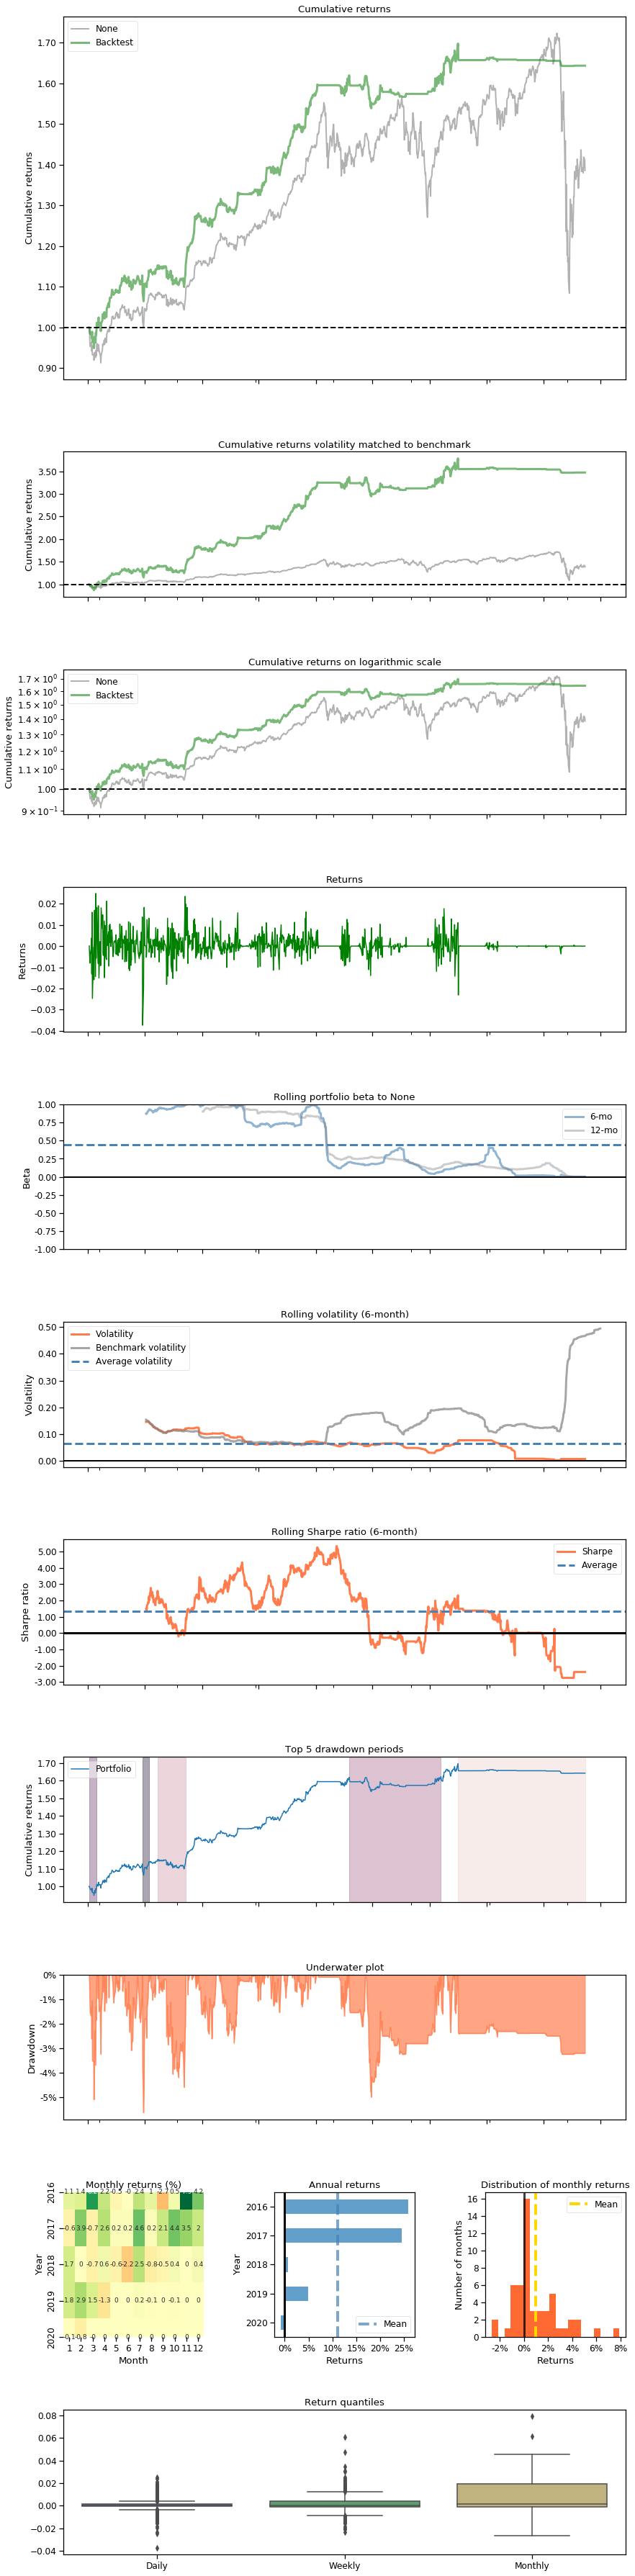

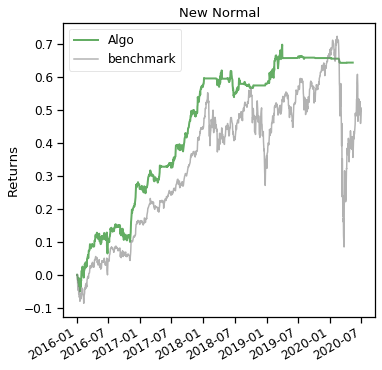

In [ ]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat, benchmark_rets=dow_strat, set_context=False)